# <center>Part 1</center>

**The code below up to 1.2 is taken from the TP and needs to be modified.**

# Import

In [ ]:
import numpy as np                     # Numerical algorithms on arrays
import cv2                             # OpenCV
from matplotlib import pyplot as plt   # Plot library
import matplotlib.cm as cm             # Image color map 
import edge_detector as ed             # A edge detector
import segment_detector as sd          # A segment detector
import imgTools                        # A image tools

##   1.1. Loading and displaying OpenCV images

In [ ]:
# Load images
building = cv2.imread('image_database/Building.png')
building_gray = cv2.imread('image_database/Building.png', cv2.IMREAD_GRAYSCALE)
road_gray = cv2.imread('image_database/Road.png', cv2.IMREAD_GRAYSCALE)
road = cv2.imread('image_database/Road.png')

In [ ]:
def display(title, img):
    return imgTools.display(title, img)

def multiDisplay(titles, imgs, imgPerLine):
    return imgTools.multiDisplay(titles, imgs, imgPerLine)

# Display the image
multiDisplay(['Color image', 'Color image displayed in grayscale'], [building, road_gray], 2)

## 1.2. Edge points extraction

### 1.2.1 Morphological Gradient of Beucher

Test different sizes of kernel. Nothing seems to be working well. The method is dropped without further research.

In [ ]:
# Choose the kernel for the Gradient of Beucher
from ipywidgets import interact, fixed


def update(kSize=2):
    for img in [building_gray, road_gray] : 
        imgEdges = ed.gradientOfBeucher(img, kSize, kSize)
        display('Edge extraction using Morphological Gradient of Beucher', imgEdges)

interact(update, kSize = (0, 20, 1))

GRADIENT_K_SIZE = 2

### 1.2.2 Non linear Laplacian

In [ ]:
# Choose the kernel for the Gradient of Beucher
from ipywidgets import interact, fixed


def update(kSize=2):
    for img in [building_gray, road_gray] : 
        imgEdges = ed.nonLinearLaplacian(img, kernel_type=cv2.MORPH_RECT, k1=kSize, k2=kSize)
        display('Edge extraction using non linear Laplacian', imgEdges)

interact(update, kSize = (0, 20, 1))

GRADIENT_K_SIZE = 2

In [ ]:
# Test the previous one with different threshold
from ipywidgets import interact, fixed


def update(thresh=10):
    for img in [building_gray, road_gray] : 
        imgEdges = ed.nonLinearLaplacian(img, kernel_type=cv2.MORPH_RECT, k1=GRADIENT_K_SIZE, k2=GRADIENT_K_SIZE)
        threshValue, imgThresh = cv2.threshold(imgEdges,thresh,255,cv2.THRESH_BINARY)
        display('Edge extraction using non linear Laplacian - Binary thresholding', imgThresh)

interact(update, thresh = (0, 50, 2))

### 1.2.3 Canny algorithm

Vanilla version

In [ ]:
imgsToDetect = [building, road, road_gray]
imgsName = ["Building", "Road", "Road gray"]

for i in range(len(imgsToDetect)):
    imgEdges = ed.canny_vanilla(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)




In [ ]:
# Canny with less details
# Dilation can be used to thicken the edge detected


def canny_less_details(img):
    #imgEdges = ed.canny_gaussian_blur(img)
    #return imgEdges
    
    # Downsize the image
    lower_reso = cv2.pyrDown(img)
    sigma = 5
    kSize = 3
    
    # Apply gaussian blur
    lower_reso = cv2.GaussianBlur(lower_reso, (kSize,kSize), sigma)

    # Upsize the image
    higher_reso = cv2.pyrUp(lower_reso)
    
    
    # apply automatic Canny edge detection using the computed median
    med = np.median(higher_reso)
    sigma = 0
    lo_thresh = int(max(0, (1.0 - sigma) * med))
    lo_thresh = 0
    hi_thresh = int(min(255, (1.0 + sigma) * med))
        
    return cv2.Canny(higher_reso, lo_thresh, hi_thresh)

imgsToDetect = [building, road]
imgsName = ["Building", "Road"]

for i in range(len(imgsToDetect)):
    imgEdges = canny_less_details(imgsToDetect[i])

    display('Edge extraction using Canny algorithm - '+imgsName[i], imgEdges)

## 1.3. Segments and endpoints detection

### 1.3.1. Probabilistic Hough Transform

In [ ]:
THRESH_VALUE = 10
def edgesDetectionFinal(img):
    #imgEdges = ed.canny_gaussian_blur(img)
    #return imgEdges
    
    # Downsize the image
    lower_reso = cv2.pyrDown(img)
    sigma = 5
    kSize = 3
    
    # Apply gaussian blur
    lower_reso = cv2.GaussianBlur(lower_reso, (kSize,kSize), sigma)

    # Upsize the image
    higher_reso = cv2.pyrUp(lower_reso)
    
    
    # apply automatic Canny edge detection using the computed median
    med = np.median(higher_reso)
    sigma = 0
    lo_thresh = int(max(0, (1.0 - sigma) * med))
    lo_thresh = 0
    hi_thresh = int(min(255, (1.0 + sigma) * med))
        
    return cv2.Canny(higher_reso, lo_thresh, hi_thresh)


# TODO change the fct for the edge detection to the one giving the best result previously
lines, segWithEdges, seg = sd.segHough(building, edgesDetectionFinal, rho=1, theta=np.pi / 180, thresh=20, minLineLen=15,
                                       maxLineGap=4, kSize=2)
display('Segment detection - Probabilistic Hough transform', seg)
display('Segment detection - Probabilistic Hough transform - with previosu edges', segWithEdges)

In [ ]:
# Test the previous one with different threshold
from ipywidgets import interact, fixed

def update(rho=1, thresh=20, minLineLen=10, maxLineGap=4, kSize=2):
    for img in [building]:#[building, road] : 
        lines, segWithEdges, seg = sd.segHough(img, edgesDetectionFinal, rho, np.pi / 180, thresh, minLineLen,
                                        maxLineGap, kSize)
        display('Seg extraction', segWithEdges)
        display('Seg extraction without image behind', seg)

interact(update, rho = (0,10,1), thresh = (0, 50, 2), minLineLen=(0,100,5), maxLineGap=(0,20,1), kSize=(0,20,1))

### 1.3.2 Line Segment Detection algorithm

LSD is a algorithm initially written by french researchers  (Grompone R. & all) in C++ with openCV alongside a paper publish in the IPOL journal ("LSD: a Line Segment Detector", 2012) . It consists in a set of operation designed to work on most of grey images without required parameters tuning. We have used the given Python C++ binding (**pylsd**)

The algorithm consist in several defined steps:

<u>Image scaling:</u> At first, LSD proceed to a 80% scaling of the input image. This is useful to reduce noise (relating to gradient threshold for edge candidates) and to avoid aliasing and quantification artefacts, especially the staircase effect. The scale factor was empirically chosen to resolve the staircase effect. The sub-sampling of the image is done thanks to a Gaussian kernel of $\sigma=0.75$, according to the paper, this sigma value is a good trade-off between avoiding aliasing and avoiding image blurring.

<u>Gradient computation:</u> The main goal is to state the orientation and the magnitude of colour gradient for each pixel. To do so, the algorithm proceed to a simple 2x2 size kernel operation and define the *x* and *y* gradients, orientation and magnitude as follow ( i(x,y) => grey level of pixel (x,y) ):

$G_x(x,y)=\frac{i(x+1,y) + i(x+1,y+1) - i(x,y) - i(x,y+1)}{2}$

$G_y(x,y)=\frac{i(x,y+1) + i(x+1,y+1) - i(x,y) - i(x+1,y)}{2}$   

$\text{level-line angle = }arctan(\frac{G_x(x,y)}{-G_y(x,y)})$

$\text{Magnitude = } \sqrt{G^2_x(x,y) + G^2_y(x,y)}$

When the magnitudes are known, the less significant ones are dropped compare to the range observed. The algorithm then focus directly on the edges. This make it sensible to noise in relatively homogeneous image. For instance, a slight shadow on a white paper with a black point.  

<u>Region Growing:</u> It starts with the highest gradient pixel and proceed to an 8-neighbours flooding recursive call. All the pixels in the neighbour having the same orientation than the current proceeding region up to given tolerance (22.5°) are added to the region. At the end, the region will be composed of a group of pixel and will be surround by a rectangle to draw the line segment. The region orientation is initialised by the first pixel level-line angle. Then, each time a pixel is added, it updates its orientation with the following formula.

$\text{new region orientation = } arctan(\frac{\sum_{(x,y)\in Neighbour}sin(level-line-angle_{(x,y)})}{\sum_{(x,y)\in Neighbour} cos(level-line-angle_{(x,y)}})$

<u>Rectangular Approximation:</u> The determined regions are treated individually as solid object. The centre of mass of a region is computed with the magnitudes of the corresponding pixels. The dimensions of the rectangle are chosen to be the smallest possible dimension containing all the region pixel. Like in the "Mecanique des matériaux" course, the orientation of the rectangle is chosen to make it having the smallest inertia possible (Having the smallest inertia according to the main axis). It corresponds to the angle of the eigenvector associated with the smallest eigenvalue of the matrix:

$M=(\begin{matrix}m_{xx}&m_{xy} \\ m_{yx}&m_{yy} \end{matrix})$ with 

$m_{xx} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (x\_comp(x,y) - c_x)^2 }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 

$m_{yy} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (y\_comp(x,y) - c_y)^2 }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 

$m_{xx} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (x\_comp(x,y) - c_x)(y\_comp(x,y) - c_y) }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 


### 1.3.2 Line Segment Detection algorithm

LSD is a algorithm initially written by french researchers  (Grompone R. & all) in C++ with openCV alongside a paper publish in the IPOL journal ("LSD: a Line Segment Detector", 2012) . It consists in a set of operation designed to work on most of grey images without required parameters tuning. We have used the given Python C++ binding (**pylsd**)

The algorithm consist in several defined steps:

<u>Image scaling:</u> At first, LSD proceed to a 80% scaling of the input image. This is useful to reduce noise (relating to gradient threshold for edge candidates) and to avoid aliasing and quantification artefacts, especially the staircase effect. The scale factor was empirically chosen to resolve the staircase effect. The sub-sampling of the image is done thanks to a Gaussian kernel of $\sigma=0.75$, according to the paper, this sigma value is a good trade-off between avoiding aliasing and avoiding image blurring.

<u>Gradient computation:</u> The main goal is to state the orientation and the magnitude of colour gradient for each pixel. To do so, the algorithm proceed to a simple 2x2 size kernel operation and define the *x* and *y* gradients, orientation and magnitude as follow ( i(x,y) => grey level of pixel (x,y) ):

$G_x(x,y)=\frac{i(x+1,y) + i(x+1,y+1) - i(x,y) - i(x,y+1)}{2}$

$G_y(x,y)=\frac{i(x,y+1) + i(x+1,y+1) - i(x,y) - i(x+1,y)}{2}$   

$\text{level-line angle = }arctan(\frac{G_x(x,y)}{-G_y(x,y)})$

$\text{Magnitude = } \sqrt{G^2_x(x,y) + G^2_y(x,y)}$

When the magnitudes are known, the less significant ones are dropped compare to the range observed. The algorithm then focus directly on the edges. This make it sensible to noise in relatively homogeneous image. For instance, a slight shadow on a white paper with a black point.  

<u>Region Growing:</u> It starts with the highest gradient pixel and proceed to an 8-neighbours flooding recursive call. All the pixels in the neighbour having the same orientation than the current proceeding region up to given tolerance (22.5°) are added to the region. At the end, the region will be composed of a group of pixel and will be surround by a rectangle to draw the line segment. The region orientation is initialised by the first pixel level-line angle. Then, each time a pixel is added, it updates its orientation with the following formula.

$\text{new region orientation = } arctan(\frac{\sum_{(x,y)\in Neighbour}sin(level-line-angle_{(x,y)})}{\sum_{(x,y)\in Neighbour} cos(level-line-angle_{(x,y)}})$

<u>Rectangular Approximation:</u> The determined regions are treated individually as solid object. The centre of mass of a region is computed with the magnitudes of the corresponding pixels. The dimensions of the rectangle are chosen to be the smallest possible dimension containing all the region pixel. Like in the "Mecanique des matériaux" course, the orientation of the rectangle is chosen to make it having the smallest inertia possible (Having the smallest inertia according to the main axis). It corresponds to the angle of the eigenvector associated with the smallest eigenvalue of the matrix:

$M=(\begin{matrix}m_{xx}&m_{xy} \\ m_{yx}&m_{yy} \end{matrix})$ with 

$m_{xx} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (x\_comp(x,y) - c_x)^2 }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 

$m_{yy} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (y\_comp(x,y) - c_y)^2 }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 

$m_{xx} = \frac{\sum_{(x,y)\in Region} Magnitude(x,y) . (x\_comp(x,y) - c_x)(y\_comp(x,y) - c_y) }{\sum_{(x,y)\in Region} Magnitude(x,y)}$ 


In [ ]:
# import lsd algorithm
from LSD import lsd_alg

display('Line Segment Detection with LSD - Road', lsd_alg(road_gray) )

display('Line Segment Detection with LSD - Building', lsd_alg(building_gray) )

display('Line Segment Detection with LSD - Road 1 pixel forced', lsd_alg(road_gray, line_width=1) )

display('Line Segment Detection with LSD - Building 1 pixel forced', lsd_alg(building_gray, line_width=1) )

### 1.3.3 Fusing adjacent segments

The segment detection used previously is not prefect. One of the imprefection lays in the fact of mutliple segments drawn close to each other to describe the same unique edge. In order to solve this problem, 'close segments' will be fused together.

The segments detected are given in the cartesian space with its two endpoints which makes it difficult to characterize the closeness of two edges. In contrast, the Hough space can easily describe the distance between two segments and fuse them if needed. Thus, the idea of the algorithm is to map the segments in a variant of the Hough space, fuse all close segments then map the segments back to the cartesian space.

#### Mapping from cartesian to a variant of the Hough space

Let's take the example of one segment described by the two points: $A = (a_v, a_h)$ and $B = (b_v, b_h)$ where $(i,j)$ is the point with $i$ in vertical value and $j$ in horizontal values and the origin is fixed at the top left corner of the image.

The Hough space will be described by 4 values : $\theta, \rho, p, d$

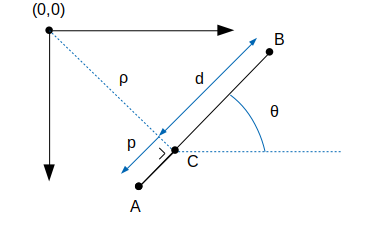

By convention, $A$ will be such that $a_h < b_h$.

**Computing $\theta$**

$$\theta = arctan \Big(\frac{|b_v - a_v|}{|b_h-a_h|} \Big)$$

Then we want to have $\theta \in ]\pi/2, \pi [$ if the slope of the line is decreasing, thus : 

$$\theta_{final} = \pi - \theta \quad \text{ if $a_v < b_v$}$$

**Computing $\rho$**

$$\rho = \frac{|| \overrightarrow{AB} \times \overrightarrow{OA} ||}{|| \overrightarrow{AB} ||}$$

$\rho$ must be lower than zero  when $c_h < 0$. However, $c_h$ has not been computed yet. Thus, the intersection between the line and $x = 0$ will be computed instead. If, this point has a horizontal value lower than 0, it means $c_h < 0$ and thus $\rho < 0$. 

$$\quad \left\{
    \begin{array}{ll}
      y = mx+n \\
      x  = 0
    \end{array}
  \right.$$ 
$$\Leftrightarrow \left\{
    \begin{array}{ll}
      y = \frac{a_h-b_h}{a_v-b_v}x+(a_h - a_v \frac{a_h-b_h}{a_v-b_v}) \\
      x  = 0
    \end{array}
  \right.$$ 
$$\Leftrightarrow \left\{
    \begin{array}{ll}
      y = a_h - a_v \frac{a_h-b_h}{a_v-b_v} \\
      x  = 0
    \end{array}
  \right.$$ 

Thus, $$\rho_{final} = - \rho \quad \text{ if $a_h - a_v \frac{a_h-b_h}{a_v-b_v} < 0$}$$


**Computing C**
$$c_v = \rho * cos(\theta)$$
$$c_h = \rho * sin(\theta)$$

**Computing $p$ and $d$**
$$p = \left\{
        \begin{array}{ll}
          -sign(c_h-a_h) * ||\overrightarrow{AC}|| & \text{ if } a_h < b_h \text{ or } (a_h = b_h \text{ & } a_v > b_v) \\
          -sign(c_h-b_h) * ||\overrightarrow{BC}|| & \text{ else }
        \end{array}
      \right.$$
$$d = ||\overrightarrow{AB}||$$


#### Mapping back from the variant of the Hough space to  the cartesian space
This action allows to go back in the cartesian space after fusing the close segments.

**Computing C**
$$c_v = \rho * cos(\theta)$$
$$c_h = \rho * sin(\theta)$$

**Computing A and B**
$$A : \left\{
        \begin{array}{ll}
          a_v =  c_v - sign(\frac{\pi}{2}-\theta) * p * sin(\theta)\\
          a_h =  c_h + sign(\frac{\pi}{2}-\theta) * p * cos(\theta)
        \end{array}
      \right.$$
$$B : \left\{
        \begin{array}{ll}
          b_v = c_v - sign(\frac{\pi}{2}-\theta) * (p+d) * sin(\theta) \\
          b_h = c_h + sign(\frac{\pi}{2}-\theta) * (p+d) * cos(\theta)
        \end{array}
      \right.$$

#### Fusing two segments
Two segments will be fused together if they fulfill the conditions below:

$$\left\{
        \begin{array}{ll}
          \Big| \theta_1-\theta_2\Big| \leq \Delta_{\theta}\\
          \Big| \rho_1-\rho_2\Big| \leq \Delta_{\rho}\\
          \Big( p_1 \leq p_2 \quad \text{ & } \quad p_1+d_1 > p_2 \Big) \text{ or }
				    \Big( p_2 \leq p_1  \quad \text{ & } \quad  p_2+d_2 > p_1 \Big)
        \end{array}
      \right.$$

The two first conditions are restricting the orientation and position of the lines extending the segments while the last one restrict the position of the segment on the line.


Then to fuse two segments, the two segments are removed and a new one is created with the following values:

$$\left\{
        \begin{array}{ll}
          \theta_n = \frac{\theta_1+\theta_2}{2}\\
          \rho_n = \frac{\rho_1+\rho_2}{2}\\
          p_n = min(p_1, p_2)\\
          d_n = max(p_1+d_1, p_2+d_2) - p_n
        \end{array}
      \right.$$



In [ ]:
lines, segWithEdge, seg = sd.segHough(building, canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                      minLineLen=15, maxLineGap=4, kSize=2)

def update(dRho=1, dTheta=1/360*np.pi*2):
    lines2, segWithEdge2, seg2 = sd.segHough(building, canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=dTheta,
                                             dRho = dRho)
    multiDisplay([f"Segments with previously detected edges - {len(lines)} segments", 
                  f"Segments with previously detected edges - {len(lines2)} segments - segments fused",
                  f"Segments - {len(lines)} segments",
                  f"Segments - {len(lines2)} segments - segments fused"],
                 np.array([segWithEdge, segWithEdge2, seg, seg2]), 2)
    display(f"Segments - {len(lines2)} segments - segments fused",
             seg2)

interact(update, dRho = (0,10,1), dTheta = (1/360*np.pi*2, 20/360*np.pi*2, 1/360*np.pi*2))

## 1.4. Segments and endpoints classification

In [ ]:
seg, edges, line_edges, not_line_edges = ec.edge_classifier(building)
display('Segment classification - Segments',seg)
display('Segment classification - Edges', edges)
display('Segment classification - Segment Edges', line_edges)
display('Segment classification - Not Segment Edges', not_line_edges)


## 1.5. Evaluation on databases

In [ ]:
# Getting the images

import os
sudoku = []
soccer = []
road = []
pcb = []
building = []

sudokuFolder = 'image_database/sudoku'
soccerFolder = 'image_database/soccer'
roadFolder = 'image_database/road'
pcbFolder = 'image_database/pcb'
buildingFolder = 'image_database/building'

sudokuNames = sorted([img for img in os.listdir(sudokuFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in sudokuNames:
   sudoku.append(cv2.imread(sudokuFolder+'/'+name))

soccerNames = sorted([img for img in os.listdir(soccerFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in soccerNames:
   soccer.append(cv2.imread(soccerFolder+'/'+name))

roadNames = sorted([img for img in os.listdir(roadFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in roadNames:
   road.append(cv2.imread(roadFolder+'/'+name))

buildingNames = sorted([img for img in os.listdir(buildingFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in buildingNames:
   building.append(cv2.imread(buildingFolder+'/'+name))

pcbNames = sorted([img for img in os.listdir(pcbFolder) if img.endswith(".png")]) # ref : https://www.geeksforgeeks.org/python-create-video-using-multiple-images-using-opencv/
for name in pcbNames:
   pcb.append(cv2.imread(pcbFolder+'/'+name))

### 1.5.1. Sudoku

In [ ]:
for i in range(10):
    lines2, segWithEdge2, seg2 = sd.segHough(sudoku[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{sudokuNames[i]} - {len(lines2)} segments",seg2)

### 1.5.2. Soccer

In [ ]:
for i in range(10):
    lines2, segWithEdge2, seg2 = sd.segHough(soccer[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{soccerNames[i]} - {len(lines2)} segments",seg2)

### 1.5.3. Road

In [ ]:
for i in range(10):
    lines2, segWithEdge2, seg2 = sd.segHough(road[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{roadNames[i]} - {len(lines2)} segments",seg2)

### 1.5.4. Pcb

In [ ]:
for i in range(10):
    lines2, segWithEdge2, seg2 = sd.segHough(pcb[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=2/360*np.pi*2,
                                             dRho = 2)
    display(f"{pcbNames[i]} - {len(lines2)} segments",seg2)

### 1.5.5. Building

In [ ]:
for i in range(10):
    lines2, segWithEdge2, seg2 = sd.segHough(building[i], canny_less_details, rho=1, theta=np.pi / 180, thresh=20, 
                                             minLineLen=15, maxLineGap=4, kSize=2, fuse=True, dTheta=1/360*np.pi*2,
                                             dRho = 2)
    display(f"{buildingNames[i]} - {len(lines2)} segments",seg2)